In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Qestion 1)

The question asks us to solve (via the relaxation method) the electric field of a charged spherical cylinder. In 2D this would look like a circular cross section. Let's assume it is inside a box where the walls are grounded at zero potential.

'\n#mask[ n//2:n//2+n//16, n//2-n//8:n//2+n//8]=True #what cells in grid to apply to (rod in center)\n#bc[n//2:n//2+n//16,n//2-n//8:n//2+n//8]=1.0 #positive potential\n\nfor i in range(100): \n    sharp = 5.0 #Keep in range (0,4) where 0 is a bar and 4 is a sharp cone. Use >4 for two sources\n    mask[n//2-int(i*sharp):n//2+n//16-int(i*sharp),n//2+n//8-i:n//2+n//8+i ]=True #what cells in grid to apply to (cone at end)\n\n    if n//2 < int(i*sharp):\n        bc[n//2-int(i*sharp):n//2+n//16-int(i*sharp),n//2+n//8-i:n//2+n//8+i]=-1.0 #negative potential or ground\n    else:\n        bc[n//2-int(i*sharp):n//2+n//16-int(i*sharp),n//2+n//8-i:n//2+n//8+i]=1.0 #positive potential\n'

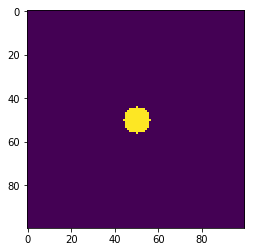

In [2]:
#First, let's start with the geometry. Let's do it in 2D

n_res=100 #resolution of initial grid

MaxIter = 30*n_res #max number of iterations before stopping
ThresholdResid = 1e-15 #Threshold to hit to deem acceptable

mask=np.zeros([n_res,n_res],dtype='bool')

def wall_bc(bc, mask, val=0.0):
    #print(pot_grid.size)
    #print(pot_grid)
    #mask=np.zeros([pot_grid.shape[0],pot_grid.shape[1]],dtype='bool')
    mask[:,0]=True
    mask[:,-1]=True
    mask[0,:]=True
    mask[-1,:]=True
    bc[mask] = val
    #pot_grid[:,-1] = val
    #pot_grid[-1,:] = val
    #pot_grid[0,:] = val
    #print(pot_grid)
    return bc.copy(), mask



def circle_bc(bc, mask, val=1.0):
    
    center=[bc.shape[0]//2, bc.shape[1]//2]
    radius = bc.shape[0]//16
    #print(center)
    
    #print(center)
    #print(radius)
    
    for i in range(bc.shape[0]):
        for j in range(bc.shape[1]):
            if (((i-center[0])**2 + (j-center[1])**2) <= radius**2):
                bc[i,j] = val
                mask[i,j] = True
    
    #print(pot_grid)
    return bc.copy(), mask

#The potential matrix
V=np.zeros([n_res,n_res]) 

#Boundary condition says all walls are grounded

bc = wall_bc(V, mask, 0.0)[0]
bc =circle_bc(bc, mask, 1.0)[0]

V[mask] = bc[mask]

plt.imshow(V)

#Some more interesting geometry for fun
'''
#mask[ n//2:n//2+n//16, n//2-n//8:n//2+n//8]=True #what cells in grid to apply to (rod in center)
#bc[n//2:n//2+n//16,n//2-n//8:n//2+n//8]=1.0 #positive potential

for i in range(100): 
    sharp = 5.0 #Keep in range (0,4) where 0 is a bar and 4 is a sharp cone. Use >4 for two sources
    mask[n//2-int(i*sharp):n//2+n//16-int(i*sharp),n//2+n//8-i:n//2+n//8+i ]=True #what cells in grid to apply to (cone at end)

    if n//2 < int(i*sharp):
        bc[n//2-int(i*sharp):n//2+n//16-int(i*sharp),n//2+n//8-i:n//2+n//8+i]=-1.0 #negative potential or ground
    else:
        bc[n//2-int(i*sharp):n//2+n//16-int(i*sharp),n//2+n//8-i:n//2+n//8+i]=1.0 #positive potential
'''


In [18]:
#Relaxation method
def relaxation(V, MaxIter=30*n_res):
    residual_relax = 1.0
    i=0
    while(i<MaxIter and residual_relax > ThresholdResid):
        V[1:-1,1:-1]=(V[1:-1,0:-2]+V[1:-1,2:]+V[:-2,1:-1]+V[2:,1:-1])/4.0 #average neighbours
        

        V[mask] = bc[mask]
        
        if i>0:
            residual_relax = np.sum((V-V_old)**2.) #not really the residual but wtv
        
        V_old = V.copy()

        if i%1000==0:
            print("On iteration", i, " the residual is %.2e"%residual_relax)
        i+=1

    if i<MaxIter:
        print("Achieved threshold tolerance after ", i, " iterations")
    elif i>=MaxIter:
        print("Reached maximum number of iterations achieving tolerance of ", residual_relax)

    numIter_relax = i

    rho=V[1:-1,1:-1]-(V[1:-1,0:-2]+V[1:-1,2:]+V[:-2,1:-1]+V[2:,1:-1])/4.0 #The charge
    
    return V, rho, i, residual_relax



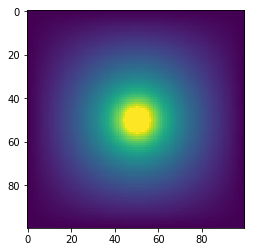

('On iteration', 0, ' the residual is 1.00e+00')
('On iteration', 1000, ' the residual is 2.80e-12')
('On iteration', 2000, ' the residual is 4.07e-13')
('Reached maximum number of iterations achieving tolerance of ', 5.938558516489021e-14)


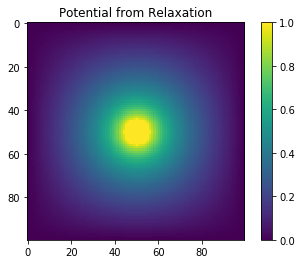

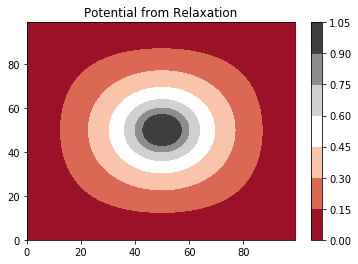

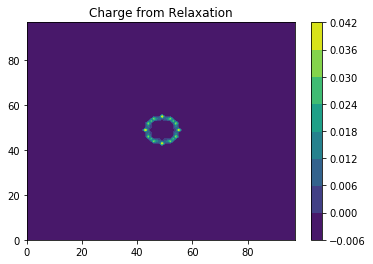

In [19]:
plt.imshow(V)
plt.show()

V_relax, rho_relax, iter_relax, residual_relax = relaxation(V, MaxIter)

plt.imshow(rho_relax) #charge should only be on the conductor surface!
plt.colorbar()

    

plt.clf()
plt.imshow(V_relax)
plt.title('Potential from Relaxation')
plt.colorbar()
plt.show()
plt.clf()
plt.contourf(V_relax, cmap='RdGy')
plt.title('Potential from Relaxation')
plt.colorbar()
plt.show()
#plt.imshow(rho, vmin=0.1, vmax=0.12)
plt.contourf(rho_relax)
plt.title('Charge from Relaxation')
plt.colorbar()
plt.show()

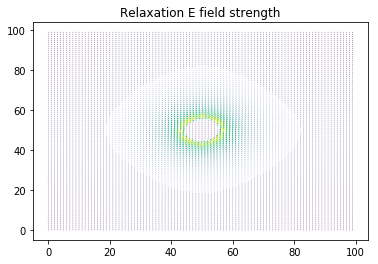

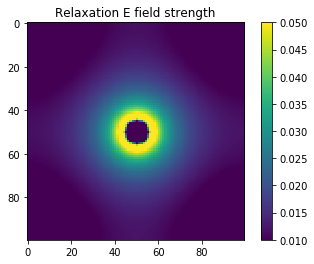

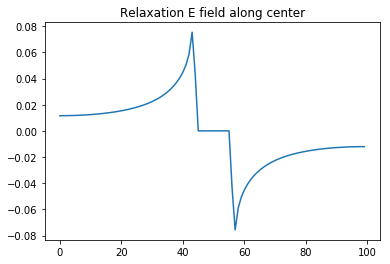

In [20]:
#Plot the electric field
skip=1 #why can't I skip values???
R = np.sqrt(np.gradient(V_relax,1.0)[0]**2. + np.gradient(V_relax,1.0)[1]**2.)
plt.quiver(np.arange(0,n_res)[::skip], np.arange(0,n_res)[::skip],np.gradient(V_relax, 1.0)[0][::skip], np.gradient(V_relax, 1.0)[1][::skip],R[::skip],  color='0.5', 
           units='height', scale=1.0/0.25, pivot='mid')
plt.title('Relaxation E field strength')
plt.show()

plt.clf()
plt.imshow(np.sqrt(np.gradient(V_relax,1.0)[0]**2. + np.gradient(V_relax,1.0)[1]**2.), vmin=0.01, vmax=0.05)
plt.colorbar()
plt.title('Relaxation E field strength')
plt.show()


plt.clf()
plt.title('Relaxation E field along center')
plt.plot(np.arange(n_res),np.gradient(V_relax[:,n_res//2]))


## Quetion 2) 

Now let's go for the conjugate gradient approach...

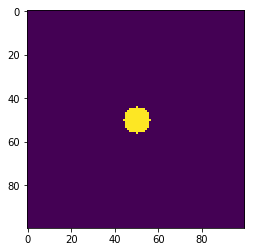

on iteration 0 residual is 1.18e+02
('Surpassed maximum relaxation residual after', 249, ' iterations.')
('Same tolerance achieved in ', 0.083, 'the number of iterations')
('Achieved threshold tolerance of ', 1e-15, ' after ', 295, ' iterations')


In [22]:
#print('residual relax is '+repr(residual_relax))

def Ax(V,mask):
    
    Vuse=V.copy()
    Vuse[mask]=0
    ans=(Vuse[1:-1,:-2]+Vuse[1:-1,2:]+Vuse[2:,1:-1]+Vuse[:-2,1:-1])/4.0
    ans=ans-V[1:-1,1:-1]
    
    return ans

def conj_grad(V, MaxIter, mask):
    
    b=-(bc2[1:-1,0:-2]+bc2[1:-1,2:]+bc2[:-2,1:-1]+bc2[2:,1:-1])/4.0
    
    #print('b shape is '+repr(b.shape))
    
    b[mask[1:-1, 1:-1]] = 0

    r=b-Ax(V,mask)
        
    p=r.copy()

    residual_conj=1.0  
    surpass=False
    i=0
    
    while(i<MaxIter and residual_conj > ThresholdResid):
        V[mask] = bc2[mask]
            
        if( (residual_conj<residual_relax) and (surpass==False)):
            print("Surpassed maximum relaxation residual after", i, " iterations.")
            print("Same tolerance achieved in ",float(i)/float(iter_relax), "the number of iterations")
            surpass = True

        Ap=(Ax(np.pad(p, (1,1), mode='constant'),mask))
                
        residual_conj=np.sum(r*r)
        
        if i%1000 == 0:
            print('on iteration ' + repr(i) + ' residual is %.2e'%residual_conj)
    
        alpha=residual_conj/np.sum(Ap*p)

        V=V+np.pad(alpha*p, (1,1), mode='constant')
        rnew=r-alpha*Ap
        beta=np.sum(rnew*rnew)/residual_conj
        p=rnew+beta*p
        r=rnew
        i+=1
        
    rho=V[1:-1,1:-1]-(V[1:-1,0:-2]+V[1:-1,2:]+V[:-2,1:-1]+V[2:,1:-1])/4.0
    return V,rho, i



#Let's try it out


mask2=np.zeros([n_res,n_res],dtype='bool')


#The potential matrix
V2=np.zeros([n_res,n_res]) 

#Boundary condition says all walls are grounded

bc2 = wall_bc(V2, mask2, 0.0)[0]
bc2 =circle_bc(bc2, mask2, 1.0)[0]

V2[mask] = bc2[mask2]

plt.imshow(V2)
plt.show()



V_conj, rho_conj, iter_conj = conj_grad(V2, MaxIter, mask2)

if iter_conj<MaxIter:
    print("Achieved threshold tolerance of ",ThresholdResid," after ", iter_conj, " iterations")
else:
    print("Reached maximum number of iterations")

    

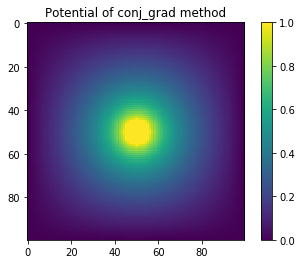

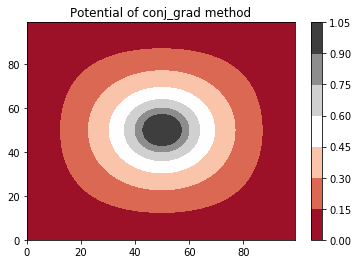

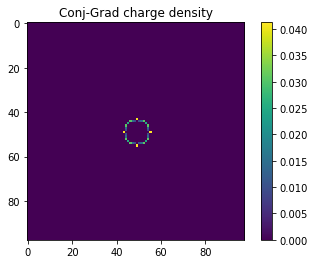

In [24]:
plt.clf()
plt.imshow(V_conj)
plt.title('Potential of conj_grad method')
plt.colorbar()
plt.show()

plt.clf()
plt.contourf(V_conj, cmap='RdGy')
plt.title('Potential of conj_grad method')
plt.colorbar()
plt.show()

plt.clf();
plt.imshow(rho_conj)
plt.title('Conj-Grad charge density')
plt.colorbar()
plt.show()

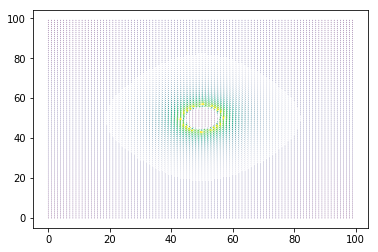

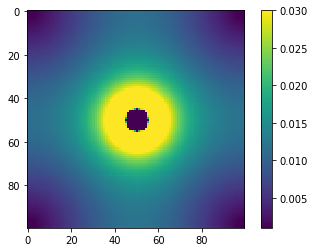

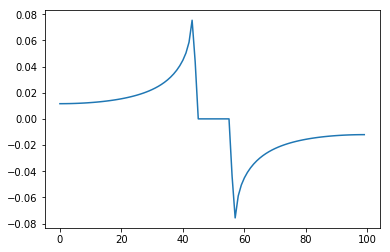

In [25]:
#Plot the electric field
skip=1 #why can't I skip values???
R = np.sqrt(np.gradient(V_conj,1.0)[0]**2. + np.gradient(V_conj,1.0)[1]**2.)
plt.quiver(np.arange(0,n_res)[::skip], np.arange(0,n_res)[::skip],np.gradient(V_conj, 1.0)[0][::skip], np.gradient(V_conj, 1.0)[1][::skip],R[::skip],  color='0.5', 
           units='height', scale=1.0/0.25, pivot='mid')
plt.show()

plt.imshow(np.sqrt(np.gradient(V_conj,1.0)[0]**2. + np.gradient(V_conj,1.0)[1]**2.), vmin=0.001, vmax=0.03)
plt.colorbar()

plt.show()
plt.imshow((np.gradient(V_conj,1.0)[0] + np.gradient(V_conj,1.0)[1]), vmin=-0.1, vmax=0.1)
plt.colorbar()

plt.clf()
plt.plot(np.arange(n_res),np.gradient(V_conj[:,n_res//2]))

# Question 3) 

Upscaling the resolution...

In [257]:
#Let's take the solution we have now and iteratively double the resolution. 
from scipy.interpolate import RegularGridInterpolator #might as well use what's available

def better_res(V, scaleFactor=2):
    MaxRes = 100

    s = V.shape
    #x,y = np.arange(s[0]), np.arange(s[1])
    
    Vnew = np.zeros([V.shape[0]*scaleFactor, V.shape[1]*scaleFactor])
    
    Vnew[::scaleFactor, ::scaleFactor] = V 
    
    circleRadius = Vnew.shape[0]//16 #1/16 of grid size
    Vnew= circle_bc(Vnew, 1.0)
    Vnew = wall_bc(Vnew, 0.0)
    
    #interpolator = RegularGridInterpolator((x,y), V, method='linear')

    #xnew = np.linspace(0, s[0]-1, s[0]*scaleFactor)
    #ynew = np.linspace(0, s[1]-1, s[1]*scaleFactor)
    
    
    
    Vsol = conj_grad(Vnew, 100)[0]
    
    if (s[0]>=MaxRes):
        return Vsol
    else:
        return better_res(Vsol, 2)
    
    '''
    Vnew = np.zeros([V.shape[0]*scaleFactor, V.shape[1]*scaleFactor])
    Vnew[::scaleFactor, ::scaleFactor] = V 
    
    #Do interpolation here
    Vi = Vnew[1::scaleFactor, 1::scaleFactor]
    Vint = griddata(Vnew[::scaleFactor, ::scaleFactor], V, Vnew[1::scaleFactor, 1::scaleFactor],method='linear')
    #xnew = np.arange(0,V.shape[0]-1, )
    #interpolate=RegularGridInterpolator((xnew, ynew), Vnew)
    Vint = Vnew[::2,::2]
    #Vint[1:-1,1:-1]=(Vnew[1:-1,0:-2]+Vnew[1:-1,2:]+Vnew[:-2,1:-1]+Vnew[2:,1:-1])/4.0 #average neighbours
    if V.shape[0] >= 800:
        return Vint
    #Vnew[mask]=bc[mask] #Reset BC to original values
    #plt.imshow(better_res(V, 2))
    #plt.show()
    return better_res(Vint, scaleFactor)
    '''

In [258]:
plt.imshow(better_res(V_relax, 2))

plt.show()
plt.imshow(V_conj)


on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the num

on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the num

on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the num

on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the num

on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the num

on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the num

on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the number of iterations')
on iteration 0 residual is 9.85e+01
('Surpassed maximum relaxation residual after', 3, ' iterations.')
('Same tolerance achieved in ', 0.002, 'the num

KeyboardInterrupt: 

# Question 4)

Now let's add our bump and check out the electric field.

on iteration 0 residual is 4.20e+02
('Surpassed maximum relaxation residual after', 183, ' iterations.')
('Same tolerance achieved in ', 0.0305, 'the number of iterations')
('Achieved threshold tolerance of ', 1e-15, ' after ', 782, ' iterations')


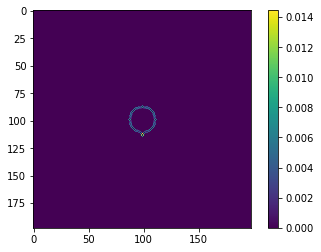

In [61]:
V=0*bc
circle(V, circleRadius/5, [n_res//2+circleRadius, n_res//2]) #Add a bump 10% of wire diameter

b=-(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0

V=0*bc #Reset the potential to zero



r=b-Ax(V,mask)
p=r.copy()

residual_conj=1.0  
surpass=False
i=0
while(i<MaxIter and residual_conj > ThresholdResid):
    
    if( (residual_conj<residual_relax) and (surpass==False)):
        print("Surpassed maximum relaxation residual after", i, " iterations.")
        print("Same tolerance achieved in ",float(i)/float(numIter_relax), "the number of iterations")
        surpass = True
    
    Ap=(Ax(np.pad(p, (1,1), mode='constant'),mask))
    residual_conj=np.sum(r*r)
    if i%1000 == 0:
        print('on iteration ' + repr(i) + ' residual is %.2e'%residual_conj)
    alpha=residual_conj/np.sum(Ap*p)

    V=V+np.pad(alpha*p, (1,1), mode='constant')
    rnew=r-alpha*Ap
    beta=np.sum(rnew*rnew)/residual_conj
    p=rnew+beta*p
    r=rnew
    i+=1
rho=V[1:-1,1:-1]-(V[1:-1,0:-2]+V[1:-1,2:]+V[:-2,1:-1]+V[2:,1:-1])/4.0

if i<MaxIter:
    print("Achieved threshold tolerance of ",ThresholdResid," after ", i, " iterations")
elif i>=MaxIter:
    print("Reached maximum number of iterations")

    
plt.clf();
plt.imshow(rho)
plt.colorbar()

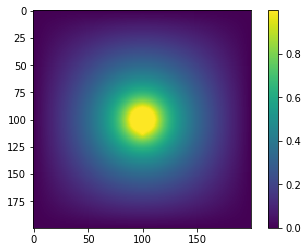

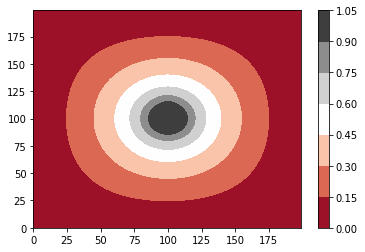

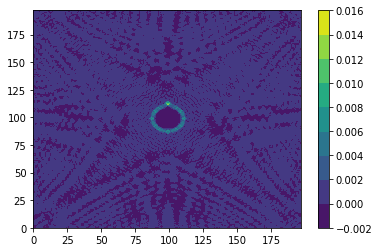

In [62]:
plt.clf()
plt.imshow(V)
plt.colorbar()
plt.show()
plt.clf()
plt.contourf(V, cmap='RdGy')
plt.colorbar()
plt.show()
#plt.imshow(rho, vmin=0.1, vmax=0.12)
plt.contourf(rho)
plt.colorbar()
plt.show()

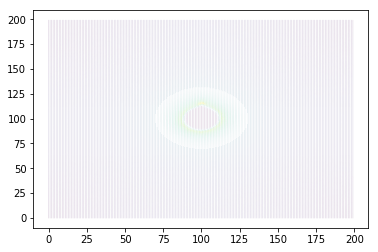

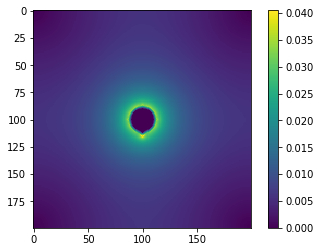

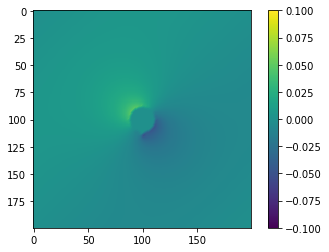

In [63]:
#Plot the electric field
skip=1 #why can't I skip values???
R = np.sqrt(np.gradient(V,1.0)[0]**2. + np.gradient(V,1.0)[1]**2.)
plt.quiver(np.arange(0,n_res)[::skip], np.arange(0,n_res)[::skip],np.gradient(V, 1.0)[0][::skip], np.gradient(V, 1.0)[1][::skip],R[::skip],  color='0.5', 
           units='height', scale=1.0/0.25, pivot='mid', alpha=0.25)
plt.show()

plt.imshow(np.sqrt(np.gradient(V,1.0)[0]**2. + np.gradient(V,1.0)[1]**2.))
plt.colorbar()

plt.show()
plt.imshow((np.gradient(V,1.0)[0] + np.gradient(V,1.0)[1]), vmin=-0.1, vmax=0.1)
plt.colorbar()